<a href="https://colab.research.google.com/github/Mbigdeli2003/Deep-Learning/blob/main/DNN_HW5_Morteza_Bigdeli_40261662001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DNN HW4 RNN Morteza Bigdeli 40261662001

## GRU RNN and Wavenet for Apple price prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

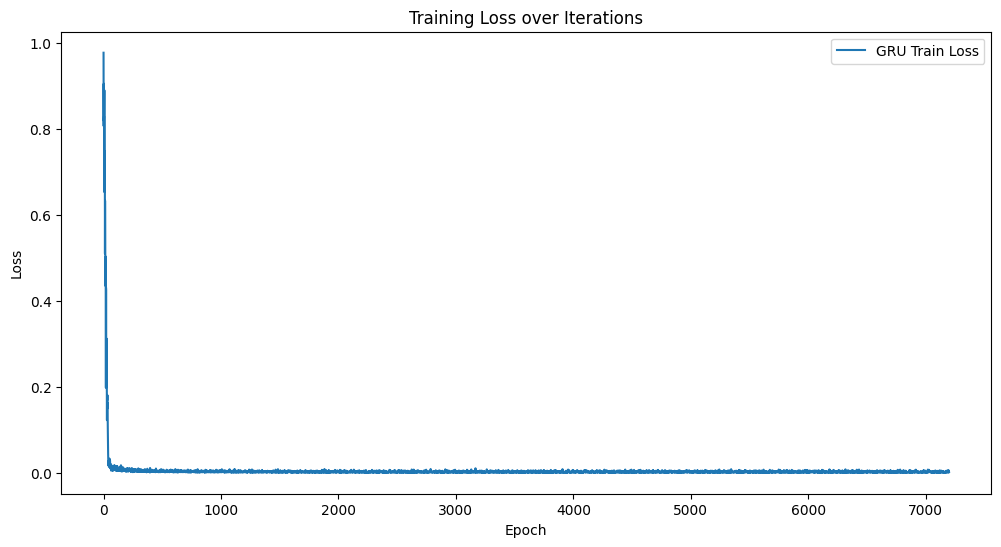

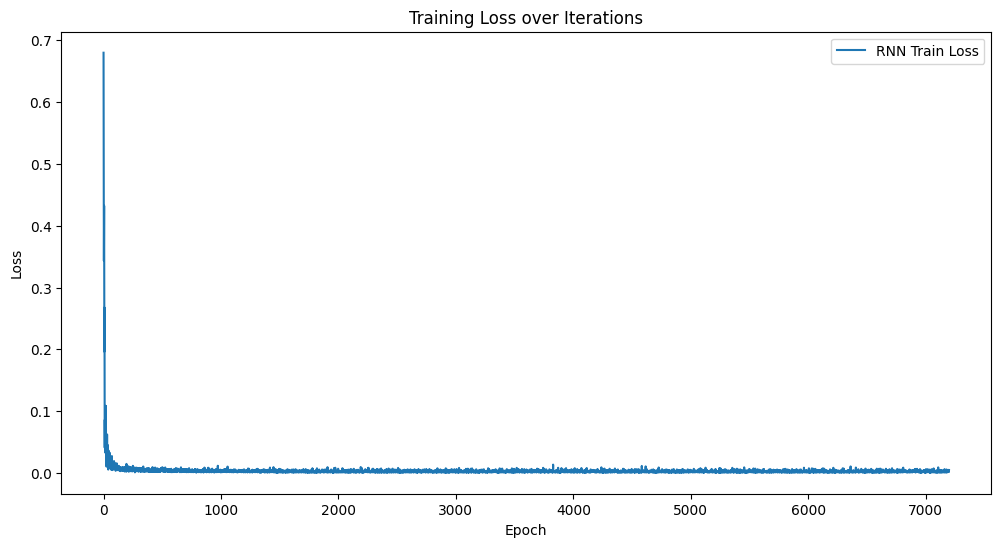

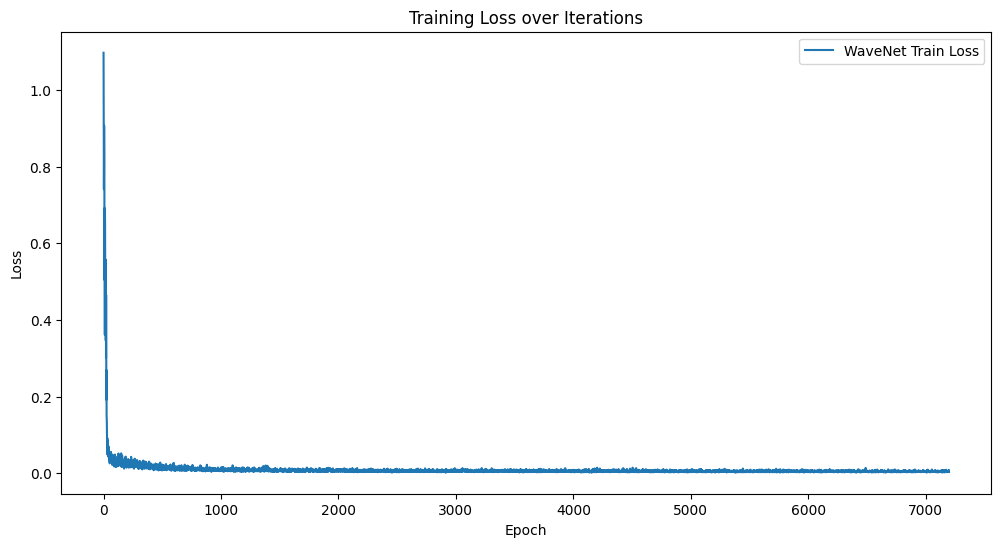

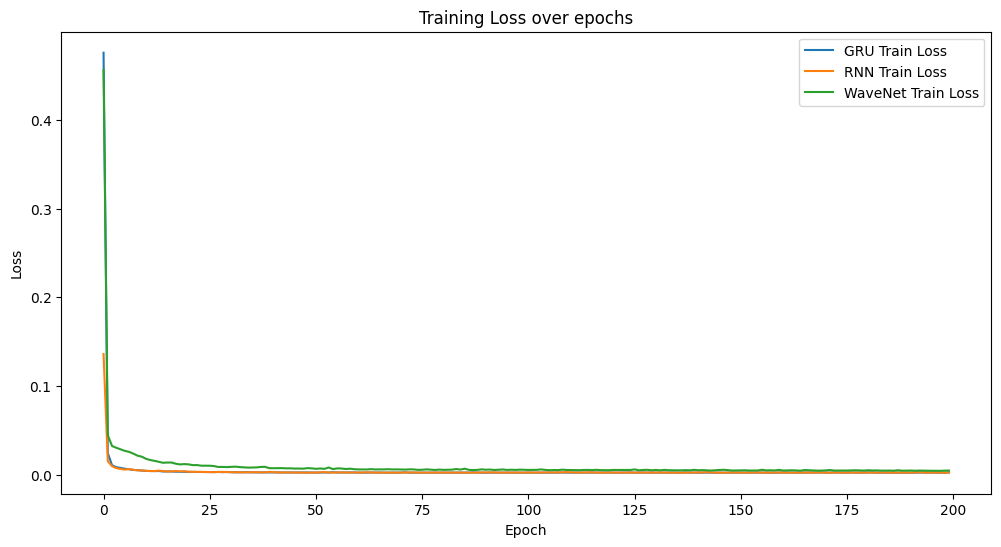

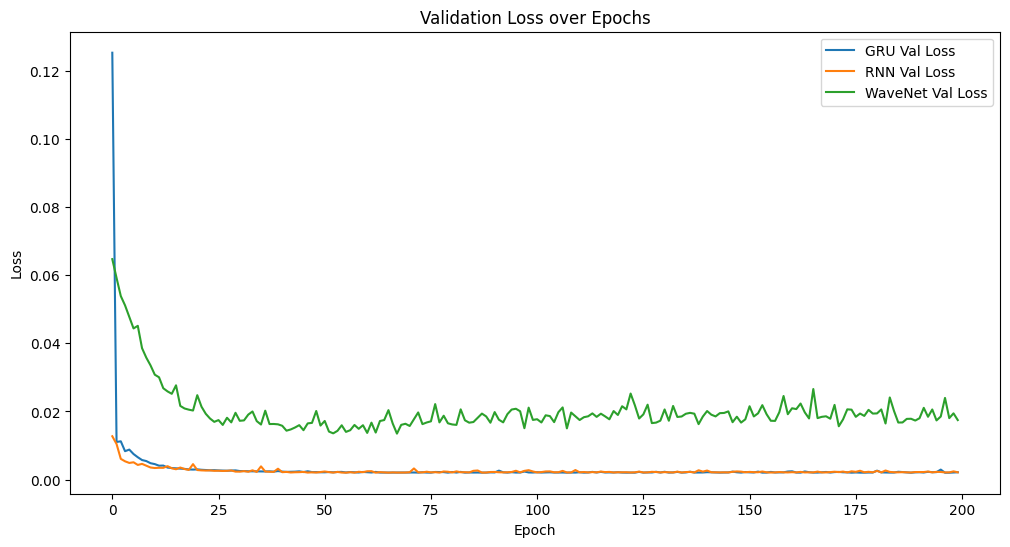

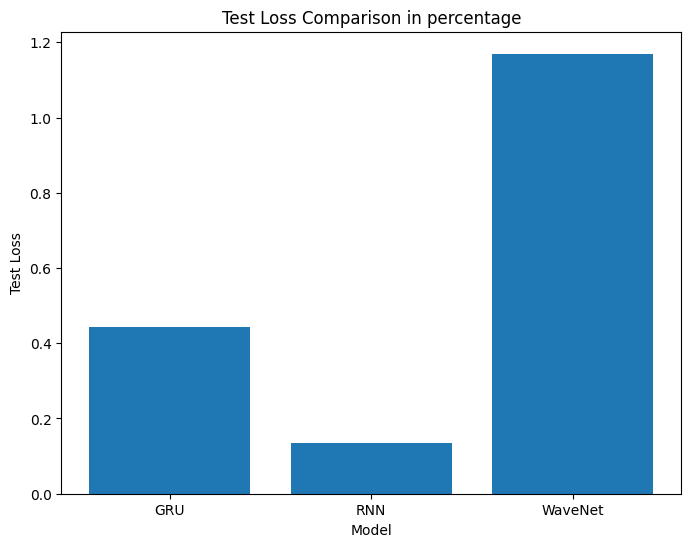

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
url = '/content/drive/MyDrive/apple_share_price.csv'
data = pd.read_csv(url)

# Preprocess the data
data['OHLC_avg'] = data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
data = data[['Date', 'OHLC_avg']]

# Normalize the data
data['OHLC_avg'] = (data['OHLC_avg'] - data['OHLC_avg'].mean()) / data['OHLC_avg'].std()

# Convert to numpy arrays
prices = data['OHLC_avg'].values
dates = data['Date'].values

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(prices, seq_length)

# Split the data into training, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the models
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

class UpdateGateRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(UpdateGateRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class WaveNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WaveNet, self).__init__()
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=2, dilation=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=2, dilation=2)
        self.conv3 = nn.Conv1d(hidden_size, hidden_size, kernel_size=2, dilation=4)
        self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=2, dilation=8)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = x.mean(dim=2)
        x = self.fc(x)
        return x

# Hyperparameters
input_size = 1
hidden_size = 32
output_size = 1
num_epochs = 200
learning_rate = 0.001

# Instantiate the models
gru_model = GRUModel(input_size, hidden_size, output_size)
rnn_model = UpdateGateRNN(input_size, hidden_size, output_size)
wavenet_model = WaveNet(input_size, hidden_size, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)
wavenet_optimizer = optim.Adam(wavenet_model.parameters(), lr=learning_rate)

# Training function
def train_model(model, optimizer, train_loader, val_loader):
    train_losses = []
    val_losses = []
    train_losses_iterations = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(-1))
            loss = criterion(outputs, y_batch.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_losses_iterations.append(loss.item())
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch.unsqueeze(-1))
                loss = criterion(outputs, y_batch.unsqueeze(-1))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

    return train_losses, val_losses, train_losses_iterations

# Train the models
gru_train_losses, gru_val_losses, gru_train_losses_iterations = train_model(gru_model, gru_optimizer, train_loader, val_loader)
rnn_train_losses, rnn_val_losses, rnn_train_losses_iterations = train_model(rnn_model, rnn_optimizer, train_loader, val_loader)
wavenet_train_losses, wavenet_val_losses, wavenet_train_losses_iterations = train_model(wavenet_model, wavenet_optimizer, train_loader, val_loader)

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch.unsqueeze(-1))
            loss = criterion(outputs, y_batch.unsqueeze(-1))
            test_loss += loss.item()
    return (test_loss / len(test_loader))*100

# Evaluate the models
gru_test_loss = evaluate_model(gru_model, test_loader)
rnn_test_loss = evaluate_model(rnn_model, test_loader)
wavenet_test_loss = evaluate_model(wavenet_model, test_loader)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(gru_train_losses_iterations, label='GRU Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Iterations')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(rnn_train_losses_iterations, label='RNN Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Iterations')
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(wavenet_train_losses_iterations, label='WaveNet Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Iterations')
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(gru_train_losses, label='GRU Train Loss')
plt.plot(rnn_train_losses, label='RNN Train Loss')
plt.plot(wavenet_train_losses, label='WaveNet Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over epochs')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(gru_val_losses, label='GRU Val Loss')
plt.plot(rnn_val_losses, label='RNN Val Loss')
plt.plot(wavenet_val_losses, label='WaveNet Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss over Epochs')
plt.show()
# Plot test loss comparison
test_losses = [gru_test_loss, rnn_test_loss, wavenet_test_loss]
labels = ['GRU', 'RNN', 'WaveNet']
plt.figure(figsize=(8, 6))
plt.bar(labels, test_losses)
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison in percentage')
plt.show()